In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# AlexNet

Some basic info:
* It uses dropout regularization
* It uses Xavier uniform initialization
* The last layers use a lot of memory and it is not so computationally efficient


In [2]:
class AlexNet (d2l.Classifier):
    def __init__(self, lr = 0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes)
        )
        self.net.apply(d2l.init_cnn)

Single - channel data example to get a summary:

In [3]:
AlexNet().layer_summary((1, 1, 224, 224))

/home/pachy/.cache/pypoetry/virtualenvs/dive_into_deep_learning-88_68WVw-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

Since AlexNet takes 224x224 images, we must rescale Fashion-MNIST to that size in order for it to work.\
Note the small learning rate due to the deeper and wider network.

In [4]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

KeyboardInterrupt: 

# Networks Using Blocks (VGG)

We can abstract out of neurons and layers by thinking about blocks, that are repeating patterns of layers, usually pretrained models.

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

## VGG blocks

It is computationally more convenient to have narrow and deep models rather than shallow and large. Two 3x3 layers touch as many pixels as a 5x5 layer, but the latter contains as much parameters as three 3x3 layers!\
Thus, we can define a `vgg_block` as a sequence of 3x3 layer (with padding of 1), followed by 2x2 maxpooling with a stride of 2.\
Note that the aforementioned convolutional layers **do not** reduce the dimensionality of the model.

In [ ]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

Some information about the network:
* There is a first part with VGG block
* There is a second part with fully connected layers
* We specify the number and specifics of VGG blocks through the variable **arch**

In [ ]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr = 0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))

        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes)
        )

        self.net.apply(d2l.init_cnn)

The original implementation is arranged in this fashion:

In [ ]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary((1, 1, 224, 224))

/home/pachy/.cache/pypoetry/virtualenvs/dive_into_deep_learning-88_68WVw-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


# Training

Note that VGG-11 is computationally more demanding than AlexNet, so we use a smaller number of channels than the original one.

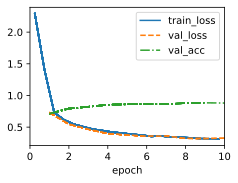

In [ ]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# Network in Network

They are based around a concept:

* Using a 1x1 convolutions to add local nonlinearities across the channel activations
* Using global average pooling to integrate across all locations at last
* Avoid fully connected layers at the end

In [1]:
import torch 
from torch import nn
from d2l import torch as d2l

In [2]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size = 1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU()
    )

The architecture bears some similarities with AlexNet.

In [3]:
class NiN (d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
        self.net.apply(d2l.init_cnn)

In [4]:
NiN().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


/home/pachy/.cache/pypoetry/virtualenvs/dive_into_deep_learning-88_68WVw-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Training

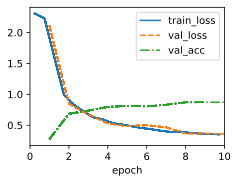

In [5]:
model = NiN(lr = 0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# Multi-Branch Networks (GoogLeNet)

It introduces a clear distinction between:
1. **Stem** (data ingest)
2. **Body** (data processing)
3. **Head** (prediction)

Moreover, it introduces concatenation of multi-branch convolutions.

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## Inception blocks

Essentially, a series of different convolutions are applied and then concatenated across channels.\
We can tune the number of output channels per layer.

In [7]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        #Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        #Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        #Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        #Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [9]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                             nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [10]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

In [11]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 128), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    

In [12]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


In [16]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

In [14]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net=nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                           self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

In [17]:
model = GoogleNet().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 416, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


# Training

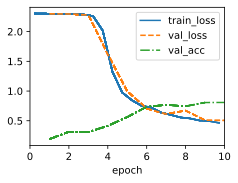

In [18]:
model = GoogleNet(lr = 0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# Batch normalization

## Implementation from scratch

In [19]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad enabled to determine wheter we are in training mode
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)

    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculating
            # mean and variance on the channel dimension (axis=1). Here we
            # need to mantain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)

        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var

    Y = gamma * X_hat + beta # Scale and shift
    return Y, moving_mean.data, moving_var.data

Scale $\gamma$ and shift $\beta$ will be updtaded with training.\
We keep track of the moving average and variance.

Note how:
1. We defined the mathematical device in a separate function
2. We will now employ the mathematical device in a layer

In [ ]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or
    # number of output channels for a convolutional layer.
    # num_dims: 2 for a fully connected layer, 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)

        # The scale parameter and the shift parameter (model parameters)
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        